# Import Necesssary Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from keras.utils import plot_model
from pylab import rcParams
rcParams['figure.figsize'] = 5, 2.5

# Importing the Dataset

In [2]:
train_dir = '../input/fer2013/train/'
test_dir = '../input/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df

train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       surprise  fear  angry  neutral   sad  disgust  happy
train      3171  4097   3995     4965  4830      436   7215
      surprise  fear  angry  neutral   sad  disgust  happy
test       831  1024    958     1233  1247      111   1774


# Basic Plots for the Data

<Axes: >

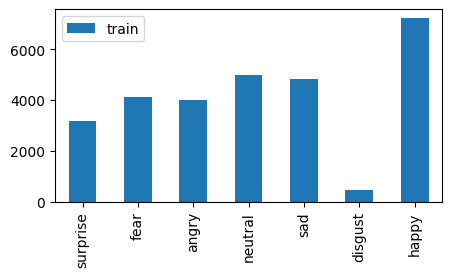

In [3]:
train_count.transpose().plot(kind='bar')

<Axes: >

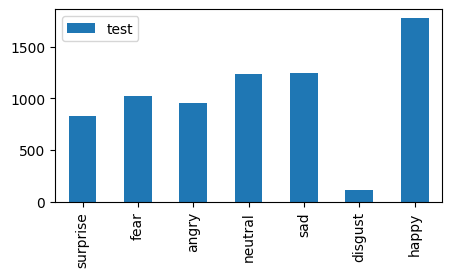

In [4]:
test_count.transpose().plot(kind='bar')

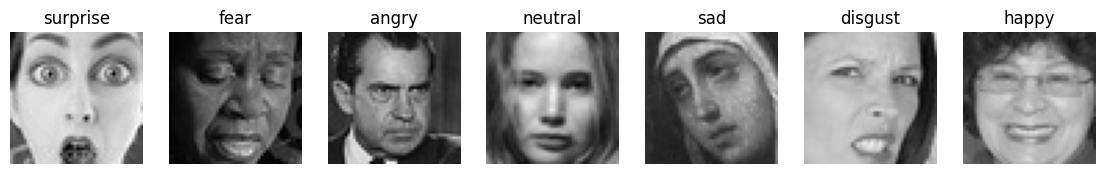

In [5]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

# Creating Training and Testing Sets

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   zoom_range=0.3,
                                   horizontal_flip=True)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [7]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

# Define the Model

In [8]:
'''
def create_model():
    input_shape=(48,48,3)

    model = Sequential()
    model.add(Dense(2304, activation = 'relu'))
    model.add(Conv2D(4, (2, 2), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, (2, 2), padding='same', activation = 'relu'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (2, 2), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(7, activation = 'softmax'))

    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')
    
    return model
'''

"\ndef create_model():\n    input_shape=(48,48,3)\n\n    model = Sequential()\n    model.add(Dense(2304, activation = 'relu'))\n    model.add(Conv2D(4, (2, 2), input_shape=input_shape, padding='same', activation = 'relu'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n\n    model.add(Conv2D(16, (2, 2), padding='same', activation = 'relu'))\n    model.add(Activation('relu'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n\n    model.add(Conv2D(64, (2, 2), activation = 'relu'))\n    model.add(MaxPooling2D(pool_size=(2, 2)))\n\n    model.add(Flatten())\n    model.add(Dense(128, activation = 'relu'))\n    model.add(Dropout(0.5))\n    model.add(Dense(7, activation = 'softmax'))\n\n    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='Adam')\n    \n    return model\n"

In [9]:
def get_model(input_size, classes=7):
     #Initialising the CNN
    model = tf.keras.models.Sequential()   

    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape =input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(classes, activation='softmax'))

    #Compliling the model
    custom_optimizer = Adam(learning_rate = 0.0001, weight_decay = 1e-6)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=custom_optimizer)
    return model

# Model Summary

In [10]:
fernet = get_model((row,col,1), classes)
fernet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

# Model Visualization

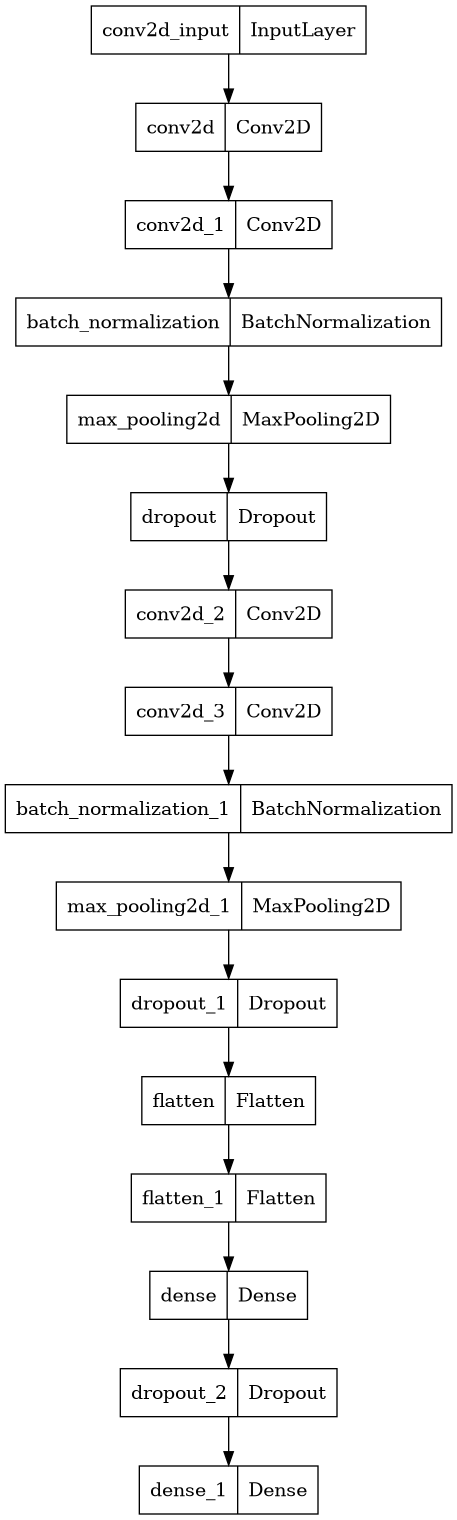

In [11]:
from keras.utils import plot_model
plot_model(fernet, to_file='model.png')

# Callbacks Function

In [12]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             moniter='val_loss')

earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=3, 
                          verbose=1, 
                          restore_best_weights=True)
                        
reduce_lr = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.2, 
                              patience=6, 
                              verbose=1, 
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

# Training Model

In [13]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60


2023-11-29 13:37:46.823330: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


448/448 [==============================] - ETA: 0s - loss: 4.3579 - accuracy: 0.2730
Epoch 1: val_loss improved from inf to 5.05431, saving model to ferNet.h5
448/448 [==============================] - 189s 399ms/step - loss: 4.3579 - accuracy: 0.2730 - val_loss: 5.0543 - val_accuracy: 0.3154 - lr: 1.0000e-04
Epoch 2/60
448/448 [==============================] - ETA: 0s - loss: 3.6337 - accuracy: 0.3276
Epoch 2: val_loss improved from 5.05431 to 3.32941, saving model to ferNet.h5
448/448 [==============================] - 45s 101ms/step - loss: 3.6337 - accuracy: 0.3276 - val_loss: 3.3294 - val_accuracy: 0.3739 - lr: 1.0000e-04
Epoch 3/60
448/448 [==============================] - ETA: 0s - loss: 3.1264 - accuracy: 0.3556
Epoch 3: val_loss improved from 3.32941 to 2.79200, saving model to ferNet.h5
448/448 [==============================] - 47s 106ms/step - loss: 3.1264 - accuracy: 0.3556 - val_loss: 2.7920 - val_accuracy: 0.4252 - lr: 1.0000e-04
Epoch 4/60
448/448 [===================

# Loss and Accuracy Plots

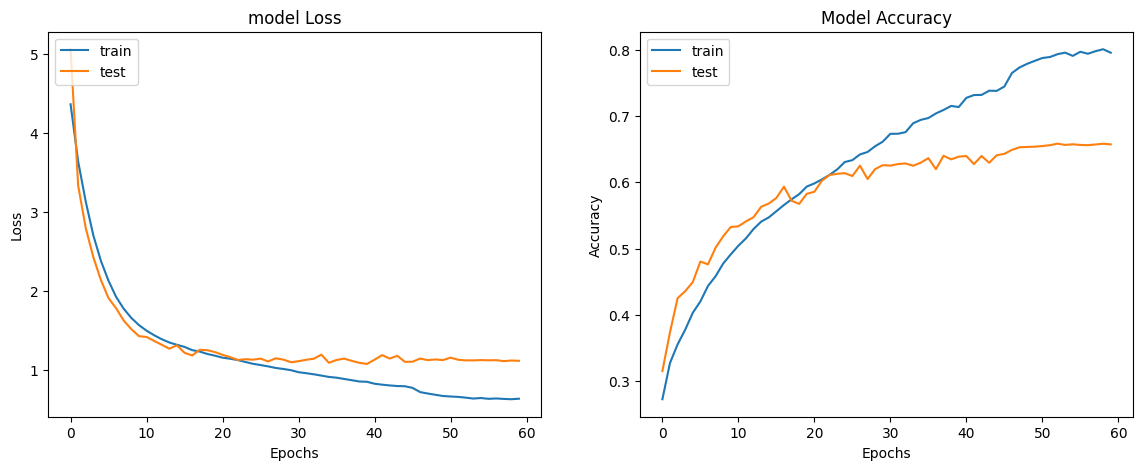

In [14]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

(48, 48)


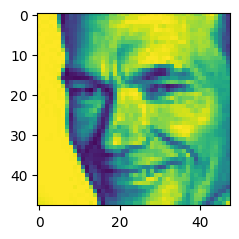

In [15]:
img = load_img("../input/fer2013/test/happy/PrivateTest_12868361.jpg",target_size = (48,48),color_mode = "grayscale")
img = np.array(img)
plt.imshow(img)
print(img.shape)

# Model Evaluation

In [16]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

113/113 [==============================] - 8s 67ms/step - loss: 1.1331 - accuracy: 0.6567
final train accuracy = 88.13 , validation accuracy = 65.67


In [17]:
fernet.save_weights('fernet_bestweight.h5')

# Confusion Matrix and Classification on Training Set

449/449 [==============================] - 35s 78ms/step
Confusion Matrix
[[ 531   52  499 1032  745  703  433]
 [  52    8   49  123   73   85   46]
 [ 561   54  531 1042  755  681  473]
 [1039  104  939 1811 1315 1192  815]
 [ 663   59  657 1299  904  836  547]
 [ 645   64  606 1272  900  828  515]
 [ 402   41  456  797  593  515  367]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.13      0.13      3995
     disgust       0.02      0.02      0.02       436
        fear       0.14      0.13      0.14      4097
       happy       0.25      0.25      0.25      7215
     neutral       0.17      0.18      0.18      4965
         sad       0.17      0.17      0.17      4830
    surprise       0.11      0.12      0.12      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



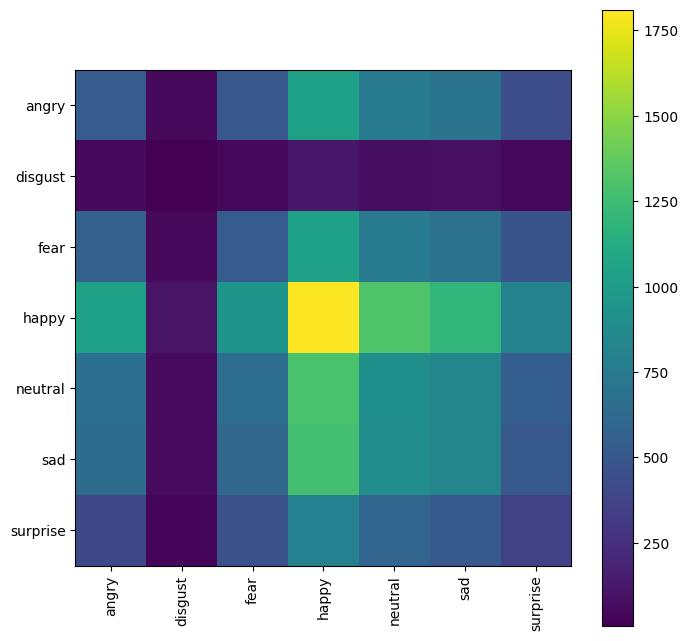

In [18]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

# Confusion Matrix and Classification on Test Set

113/113 [==============================] - 6s 55ms/step
Confusion Matrix
[[158   8 110 233 174 157 118]
 [ 19   2  16  27  20  14  13]
 [134  11 114 297 171 169 128]
 [268  17 179 438 341 325 206]
 [182  14 149 294 252 207 135]
 [158  14 131 332 242 224 146]
 [118   7  79 195 165 167 100]]
Classification Report
              precision    recall  f1-score   support

       angry       0.15      0.16      0.16       958
     disgust       0.03      0.02      0.02       111
        fear       0.15      0.11      0.13      1024
       happy       0.24      0.25      0.24      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.18      0.18      0.18      1247
    surprise       0.12      0.12      0.12       831

    accuracy                           0.18      7178
   macro avg       0.15      0.15      0.15      7178
weighted avg       0.18      0.18      0.18      7178



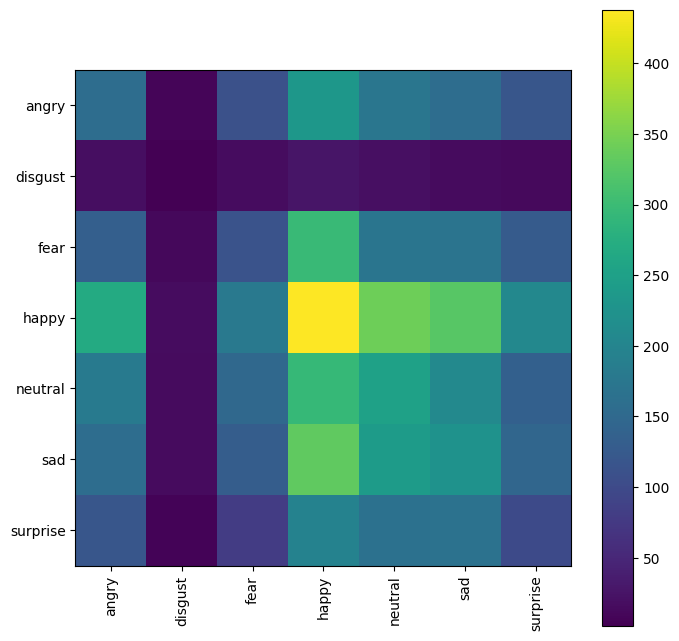

In [19]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)